## EDA - Análise exploratória de dados


Esse notebook tem por objetivo produzir as descrições de dados das emendas regionalizadas formuladas na legislatura de 2022-2025 (isto é, os vereadores eleitos em 2020).

In [1]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
import requests
from io import BytesIO
import os
import matplotlib.pyplot as plt


from config import DADOS_FINAL, DATA_FOLDER, GRAFICOS_FOLDER

In [2]:
def download_subprefeituras():

    file = os.path.join(DATA_FOLDER, 'subprefeituras.shp')

    if os.path.exists(file):
        print('Returning saved file')
        return gpd.read_file(file)

    print('Loading from geosampa')
    url = ('http://wfs.geosampa.prefeitura.sp.gov.br/geoserver/geoportal/'
        'wfs?version=1.0.0&request=GetFeature&outputFormat=SHAPE-ZIP'
        '&typeName=geoportal:subprefeitura')
    with requests.get(url) as r:
        content = BytesIO(r.content)
        subprefeituras = gpd.read_file(content)
    subprefeituras.to_file(file, driver='ESRI Shapefile')

    return subprefeituras

In [3]:
subprefeituras = download_subprefeituras()

Returning saved file


<Axes: >

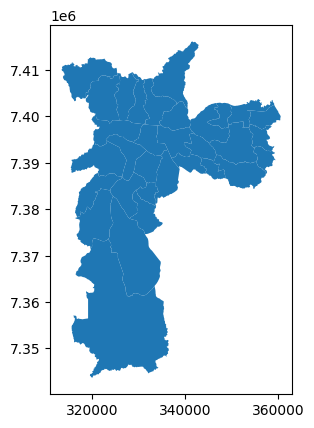

In [4]:
subprefeituras.plot()

In [5]:
def save_graph(fig, fname: str) -> str:

    fpath = os.path.join(GRAFICOS_FOLDER, fname)
    fig.savefig(fpath, format='png', bbox_inches='tight')

    return fpath


In [6]:
df = pd.read_csv(DADOS_FINAL, sep=';')

In [7]:
df.head()

,exercicio,cod_emenda,direta_ou_indireta,cod_orgao,cod_unidade,cod_programa,cod_funcao,cod_subfuncao,cod_proj_atividade,cod_fonte,...,desc_distrito,tipo_regionalizacao,valor_regionalizado,cod_vereador,motivo_emenda,apelido,cod_partido,sigla_partido,nome_partido,_merge
0,2025,3514,Administraçăo Direta,60,10,3001,13,392,9222,0,...,Supra-Distrital,Despesa Não-Regionalizável,1000.0,1814,Esta emenda visa atender as necessidades das s...,MILTON LEITE,111,UNIÃO,UNIÃO BRASIL,both
1,2025,1791,Administraçăo Direta,60,10,3022,15,452,9241,0,...,Supra-Distrital,Despesa Não-Regionalizável,2000000.0,1789,Trata-se de antiga reivindicação da comunidade...,ARSELINO TATTO,13,PT,PARTIDO DOS TRABALHADORES,both
2,2025,3514,Administraçăo Direta,60,10,3017,27,812,9223,0,...,Supra-Distrital,Despesa Não-Regionalizável,1000.0,1814,Esta emenda visa atender as necessidades das s...,MILTON LEITE,111,UNIÃO,UNIÃO BRASIL,both
3,2025,3549,Administraçăo Direta,20,10,3009,26,453,9145,0,...,Supra-Distrital,Despesa Não-Regionalizável,100000.0,1805,A presente emenda visa a melhoria na infraestr...,SIDNEY CRUZ,15,MDB,MOVIMENTO DEMOCRÁTICO BRASILEIRO,both
4,2025,3533,Administraçăo Direta,20,10,3009,26,572,9138,0,...,Supra-Distrital,Despesa Não-Regionalizável,30000.0,1805,A presente emenda destina-se a reestruturar a ...,SIDNEY CRUZ,15,MDB,MOVIMENTO DEMOCRÁTICO BRASILEIRO,both


In [8]:
df.dtypes

exercicio                int64
cod_emenda               int64
direta_ou_indireta      object
cod_orgao                int64
cod_unidade              int64
cod_programa             int64
cod_funcao               int64
cod_subfuncao            int64
cod_proj_atividade       int64
cod_fonte                int64
desc_orgao              object
desc_unidade            object
desc_programa           object
desc_funcao             object
desc_subfuncao          object
desc_proj_atividade     object
desc_fonte              object
valor_orcado             int64
index                   object
cod_regiao               int64
cod_subprefeitura        int64
cod_distrito             int64
desc_regiao             object
desc_subprefeitura      object
desc_distrito           object
tipo_regionalizacao     object
valor_regionalizado    float64
cod_vereador             int64
motivo_emenda           object
apelido                 object
cod_partido              int64
sigla_partido           object
nome_par

In [9]:
df.shape

(1076, 34)

In [10]:
df[['exercicio', 'cod_emenda', 'cod_proj_atividade', 'cod_orgao', 'cod_unidade', 'cod_subprefeitura']].duplicated().sum()

np.int64(0)

In [11]:
#identifica o total de emendas
df['index'] = df['exercicio'].astype(str) + '.' + df['cod_orgao'].astype(str) + '.' \
    + df['cod_unidade'].astype(str) +  '.' + df['cod_proj_atividade'].astype(str)

In [12]:
numero_total_de_emendas = df['index'].nunique()

print('O numero total de emendas é', numero_total_de_emendas)

O numero total de emendas é 1021


In [13]:
print('O numero total de regionalizacoes distintas das emendas é', len(df))

O numero total de regionalizacoes distintas das emendas é 1076


In [14]:
print(f'Em média, cada emenda teve {numero_total_de_emendas/len(df)} regionalizações no período')

Em média, cada emenda teve 0.9488847583643123 regionalizações no período


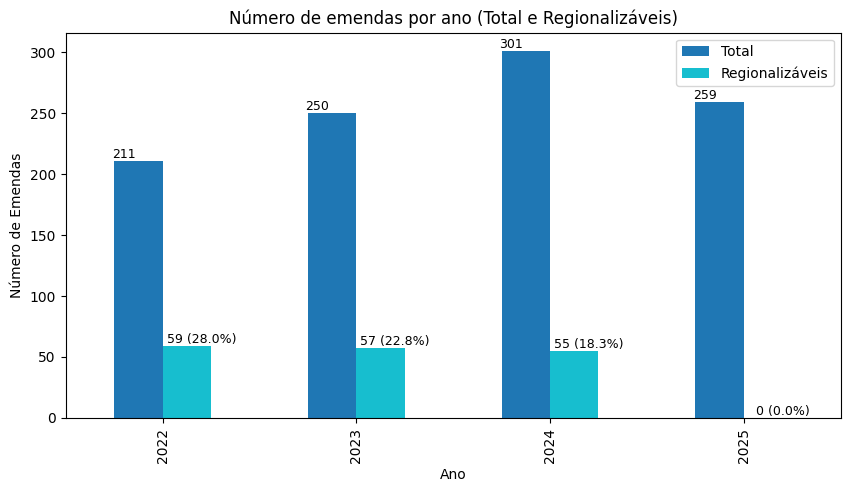

In [15]:
# Agrupa os dados por ano e calcula o total de emendas e emendas regionalizáveis
total_emendas = df.groupby('exercicio')['index'].nunique()
regionalizaveis = df[df['tipo_regionalizacao'] != 'Despesa Não-Regionalizável'].groupby('exercicio')['index'].nunique()

# Cria um DataFrame para facilitar o plot
data = pd.DataFrame({'Total': total_emendas, 'Regionalizáveis': regionalizaveis}).fillna(0)

# Plota as barras lado a lado
ax = data.plot(kind='bar', figsize=(10, 5), title='Número de emendas por ano (Total e Regionalizáveis)', colormap='tab10')

# Adiciona anotações às barras
for i, (total, regional) in enumerate(zip(data['Total'], data['Regionalizáveis'])):
    # Anota o valor total de emendas
    ax.annotate(f'{total}', (i - 0.2, total), ha='center', va='bottom', fontsize=9, color='black')
    # Calcula o percentual regionalizável
    percentage = (regional / total) * 100 if total > 0 else 0
    # Anota o valor regionalizável
    ax.annotate(f'{regional:.0f} ({percentage:.1f}%)', (i + 0.2, regional), ha='center', va='bottom', fontsize=9, color='black')

# Ajusta o layout e salva o gráfico
ax.set_ylabel('Número de Emendas')
ax.set_xlabel('Ano')
fig = ax.get_figure()
save_graph(fig, 'emendas_total_vs_regionalizaveis.png')

plt.show()

In [16]:
df['sigla_partido'].unique()

array(['UNIÃO', 'PT', 'MDB', 'NOVO', 'PSD', 'PSOL', 'PSB', 'PV',
       'REPUBLICANOS', 'PL', 'SOLIDARIEDADE', 'PP', 'PSDB', 'PODE', 'PTB',
       'PSL', 'DEM'], dtype=object)

In [17]:
espectro_partidos = {
                    'UNIÃO' : 'direita', 
                    'PT' : 'esquerda', 
                    'MDB' : 'centro', 
                    'NOVO' : 'direita', 
                    'PSD' : 'centro', 
                    'PSOL' : 'esquerda', 
                    'PSB' : 'esquerda', 
                    'PV' : 'esquerda', # esta junto com o PT na federação
                    'REPUBLICANOS' : 'direita', 
                    'PL' : 'direita', 
                    'SOLIDARIEDADE' : 'centro', 
                    'PP' : 'direita', 
                    'PSDB' : 'centro', 
                    'PODE' : 'centro', 
                    'PTB' : 'centro',
                    'PSL' : 'direita', 
                    'DEM' : 'direita'
                    }

In [18]:
df['espectro_partido'] = df['sigla_partido'].map(espectro_partidos)

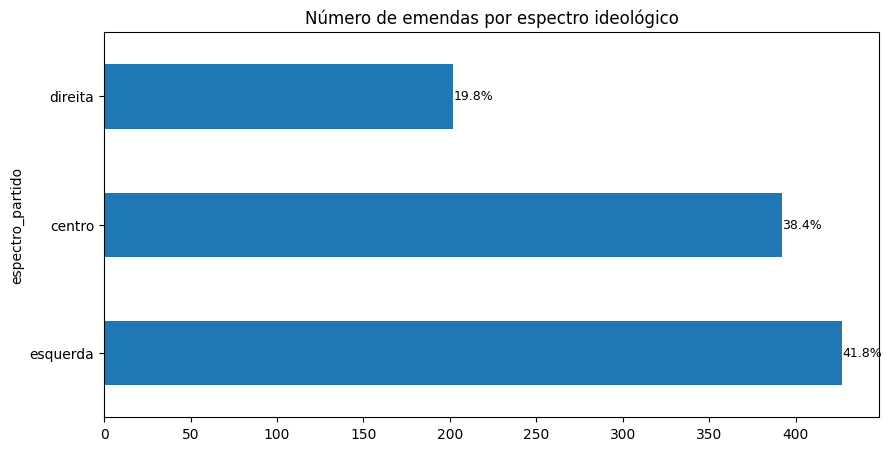

In [19]:
# Ordena os dados pela contagem de emendas em ordem decrescente
data = df.groupby('espectro_partido')['index'].nunique().sort_values(ascending=False)

# Calcula o total de emendas
total = df['index'].nunique()

# Plota o gráfico de barras horizontais
ax = data.plot.barh(title='Número de emendas por espectro ideológico', figsize=(10, 5))

# Ajusta o espaçamento entre as barras
ax.set_yticks(range(len(data)))
ax.set_yticklabels(data.index, fontsize=10)

# Adiciona os percentuais como anotações
for i, (value, label) in enumerate(zip(data, data.index)):
    percentage = (value / total) * 100
    ax.annotate(f'{percentage:.1f}%', (value, i), ha='left', va='center', fontsize=9)

# Salva o gráfico
fig = ax.get_figure()
save_graph(fig, 'emendas_por_espectro_ordenadas.png')

plt.show()

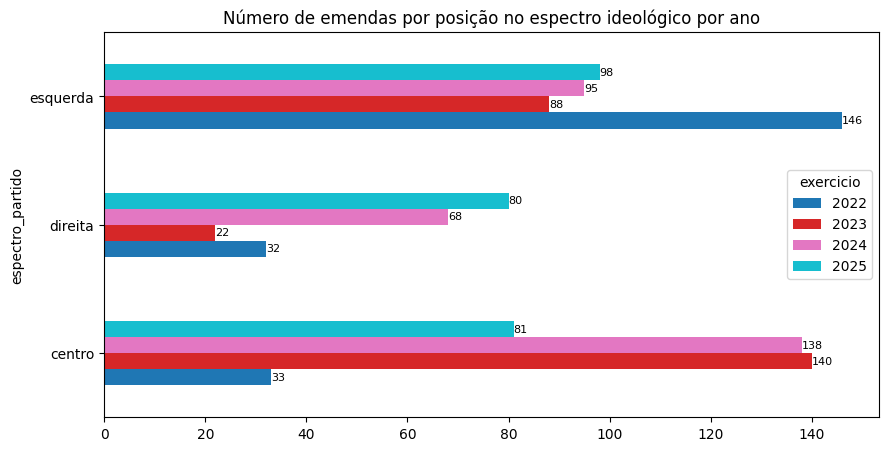

In [20]:
# Pivot the data to have 'exercicio' as columns and 'sigla_partido' as index
pivot_df = df.pivot_table(index='espectro_partido', columns='exercicio', values='index', aggfunc='nunique', fill_value=0)

# Plot the data as a grouped bar chart
ax = pivot_df.plot(kind='barh', figsize=(10, 5), title='Número de emendas por posição no espectro ideológico por ano', colormap='tab10')

# Adjust the y-axis limit
ax.set_ylim(-0.5, len(pivot_df.index) - 0.5)  # Ensures all bars are fully visible

# Add annotations to each bar
for container in ax.containers:
    ax.bar_label(container, label_type='edge', fontsize=8)

# Save the graph
fig = ax.get_figure()
save_graph(fig, 'emendas_por_espectro_ano_agrupadas.png')

plt.show()

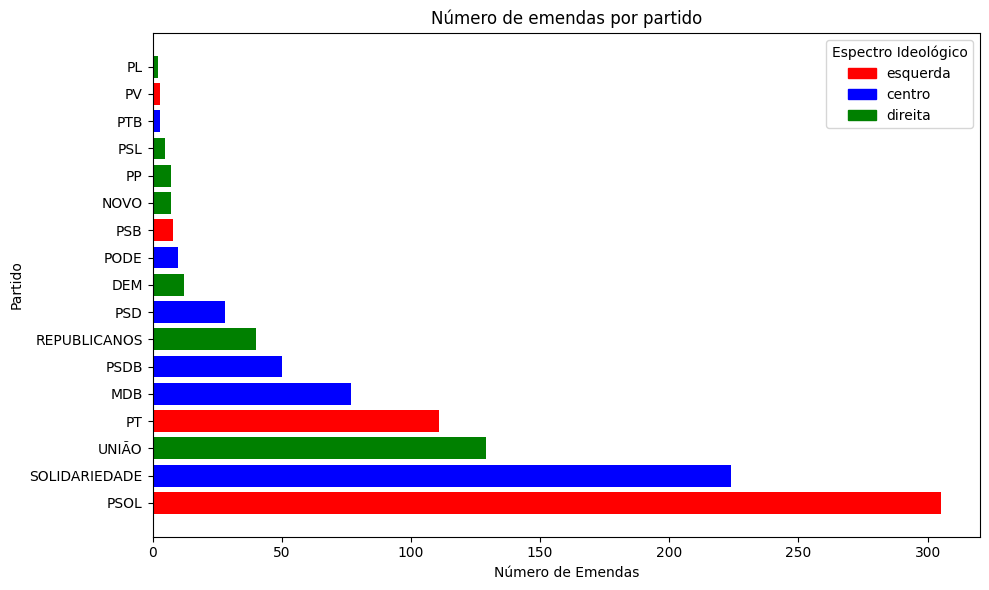

In [21]:
# Agrupa os dados por partido e espectro ideológico
data = df.groupby(['sigla_partido', 'espectro_partido'])['index'].nunique().reset_index()

# Ordena os dados pela contagem de emendas em ordem decrescente
data = data.sort_values(by='index', ascending=False)

# Define as cores para cada espectro ideológico
colors = {'esquerda': 'red', 'centro': 'blue', 'direita': 'green'}

# Plota o gráfico de barras horizontal
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.barh(data['sigla_partido'], data['index'], color=data['espectro_partido'].map(colors))

# Adiciona a legenda
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in colors.values()]
labels = colors.keys()
ax.legend(handles, labels, title='Espectro Ideológico')

# Configurações adicionais
ax.set_title('Número de emendas por partido')
ax.set_xlabel('Número de Emendas')
ax.set_ylabel('Partido')
plt.tight_layout()

# Salva o gráfico
save_graph(fig, 'emendas_por_partido_espectro_horizontal.png')

plt.show()

1 - grafico de pizza com o total de regionalizadas versus nao regionalziadas pra dar a visao do todo
2 - mapa coropletico com a quantidade de emendas por subprefeitura, independentemente do partido e do ano
3 - por posicao no espectro, mapa com o percentual de emendas por subprefeitura
4 - analise LISA para identificar clusters espaciais da posicao no espectro - final da discussao

5 (plus) - fazer a categorizacao dos motivos para deixar um final aberto

In [22]:
def identificar_categoria(motivo, palavras_chave):

    for palavra_chave in palavras_chave:
        if palavra_chave in motivo:
            return True
    else:
        return False

palavras_chave_por_motivo = {
    "Meio Ambiente e Lazer": ["praça", "parque", "área verde", "lazer"],
    "Infraestrutura Urbana": ["asfalto", "paviment", "calçada", "rua", "via", "avenida", "recape"],
    "Zeladoria": ["limpeza", "iluminação", "manutenção", "zeladoria"],
    "Esporte": ["quadra", "campo", "ginásio", "esporte"],
            }


def classificar_categoria(motivo):

    if pd.isnull(motivo):

        return "Outros ou Genérico"

    motivo = motivo.lower()

    for tema, palavras_chave in palavras_chave_por_motivo.items():
        palavras_chave = set(palavras_chave)
        if identificar_categoria(motivo, palavras_chave):
            return tema
    else:

        return "Outros ou Genérico"
    

df_merge['classificacao_motivo'] = df_merge['motivo_emenda'].apply(classificar_categoria)

NameError: name 'df_merge' is not defined